## Setup

In [1]:

!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install torchmetrics
!pip install torchvision
!pip install ipywidgets
!pip install ogb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch_geometric.transforms as T

from torch import nn
from torch_geometric.loader import DataLoader
from torch_geometric.utils import negative_sampling
from torch_geometric.nn import GCNConv
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator
from tqdm.notebook import tqdm

torch.manual_seed(0)

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    print("No GPU :(")
    device = 'cpu'

In [4]:
# load the data
dataset = PygLinkPropPredDataset(name = 'ogbl-ddi')
split_edge = dataset.get_edge_split()

# also load it as sparse matrix: needed for training
dataset = PygLinkPropPredDataset(name='ogbl-ddi', transform=T.ToSparseTensor())
graph = dataset[0] 
adj_t = graph.adj_t.to(device)

In [5]:
"""Helper functions taken from https://github.com/snap-stanford/ogb/"""

def train(model, predictor, x, adj_t, split_edge, optimizer, batch_size):

    row, col, _ = adj_t.coo()
    edge_index = torch.stack([col, row], dim=0)

    model.train()
    predictor.train()

    pos_train_edge = split_edge['train']['edge'].to(x.device)

    total_loss = total_examples = 0
    for perm in DataLoader(range(pos_train_edge.size(0)), batch_size,
                           shuffle=True):
        optimizer.zero_grad()

        h = model(x, adj_t)

        edge = pos_train_edge[perm].t()

        # computes the loss for positive edges
        pos_out = predictor(h[edge[0]], h[edge[1]])
        pos_loss = -torch.log(pos_out + 1e-15).mean()

        # samples negative edges from the graph
        edge = negative_sampling(edge_index, num_nodes=x.size(0),
                                 num_neg_samples=perm.size(0), method='dense')

        # computes the loss for negative edges
        neg_out = predictor(h[edge[0]], h[edge[1]])
        neg_loss = -torch.log(1 - neg_out + 1e-15).mean()

        loss = pos_loss + neg_loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(x, 1.0)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)

        optimizer.step()

        num_examples = pos_out.size(0)
        total_loss += loss.item() * num_examples
        total_examples += num_examples

    return total_loss / total_examples


@torch.no_grad()
def test(model, predictor, x, adj_t, split_edge, evaluator, batch_size):
    model.eval()
    predictor.eval()

    h = model(x, adj_t)

    pos_train_edge = split_edge['train']['edge'].to(x.device)
    pos_valid_edge = split_edge['valid']['edge'].to(x.device)
    neg_valid_edge = split_edge['valid']['edge_neg'].to(x.device)
    pos_test_edge = split_edge['test']['edge'].to(x.device)
    neg_test_edge = split_edge['test']['edge_neg'].to(x.device)

    # store what the link predictor outputs for each positive and negative 
    # edge in order to compute the hits@K
    pos_train_preds = []
    for perm in DataLoader(range(pos_train_edge.size(0)), batch_size):
        edge = pos_train_edge[perm].t()
        pos_train_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_train_pred = torch.cat(pos_train_preds, dim=0)

    pos_valid_preds = []
    for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
        edge = pos_valid_edge[perm].t()
        pos_valid_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_valid_pred = torch.cat(pos_valid_preds, dim=0)

    neg_valid_preds = []
    for perm in DataLoader(range(neg_valid_edge.size(0)), batch_size):
        edge = neg_valid_edge[perm].t()
        neg_valid_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    neg_valid_pred = torch.cat(neg_valid_preds, dim=0)

    pos_test_preds = []
    for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
        edge = pos_test_edge[perm].t()
        pos_test_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_test_pred = torch.cat(pos_test_preds, dim=0)

    neg_test_preds = []
    for perm in DataLoader(range(neg_test_edge.size(0)), batch_size):
        edge = neg_test_edge[perm].t()
        neg_test_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    neg_test_pred = torch.cat(neg_test_preds, dim=0)

    # compute the hits@K for training, validation, and test
    results = {}
    for K in [10, 20, 30]: 
        evaluator.K = K
        train_hits = evaluator.eval({
            'y_pred_pos': pos_train_pred,
            'y_pred_neg': neg_valid_pred,
        })[f'hits@{K}']
        valid_hits = evaluator.eval({
            'y_pred_pos': pos_valid_pred,
            'y_pred_neg': neg_valid_pred,
        })[f'hits@{K}']
        test_hits = evaluator.eval({
            'y_pred_pos': pos_test_pred,
            'y_pred_neg': neg_test_pred,
        })[f'hits@{K}']

        results[f'Hits@{K}'] = (train_hits, valid_hits, test_hits)

    return results

In [6]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim, p=0.5):
        super().__init__()

        self.conv1 = GCNConv(in_channels=input_dim, out_channels=hidden_dim)
        self.conv2 = GCNConv(in_channels=hidden_dim, out_channels=hidden_dim)
        self.conv3 = GCNConv(in_channels=hidden_dim, out_channels=out_dim)
        self.dropout = torch.nn.Dropout(p=p, inplace=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index).relu()
        x = self.dropout(x)
        x = self.conv3(x, edge_index).relu()
        return x

In [7]:
class Predictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim=1, p=0.5):
        super().__init__()

        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, out_dim)

        self.dropout = torch.nn.Dropout(p=p, inplace=False)

    def forward(self, x_i, x_j):
        x = x_i * x_j # Hadamard product
        x = self.fc1(x).relu()
        x = self.dropout(x)
        x = self.fc2(x)
        return x.sigmoid()

In [8]:
# Hyperparameters
lr = 1e-3
epochs = 100
batch_size = 512
emb_dim = 128

In [9]:
model = GNN(emb_dim, emb_dim, emb_dim).to(device)
predictor = Predictor(emb_dim, emb_dim).to(device)
evaluator = Evaluator(name='ogbl-ddi')

emb = torch.nn.Embedding(adj_t.size(0), emb_dim).to(device)
torch.nn.init.xavier_normal_(emb.weight) # initialization

params = list(model.parameters()) + list(emb.parameters()) + list(predictor.parameters())
optimizer = torch.optim.Adam(params, lr=lr)

In [10]:
# training loop

val_hits_20 = []
test_hits_20 = []
train_hits_20 = []

for epoch in tqdm(range(epochs)):
    loss = train(model, predictor, emb.weight, adj_t, split_edge, optimizer, batch_size)
    results = test(model, predictor, emb.weight, adj_t, split_edge,
                    evaluator, batch_size)

    print(f'Epoch: {epoch+1}, loss: {loss:.4f}')
    for metric, res in results.items():
        train_hits, val_hits, test_hits = res
        print('\t' + metric + ' | train: {:.4f}, val: {:.4f}, test: {:.4f}'.format(
            train_hits, val_hits, test_hits))
        if metric == 'Hits@20':
          train_hits_20.append(train_hits)
          val_hits_20.append(val_hits)
          test_hits_20.append(test_hits)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1, loss: 0.6497
	Hits@10 | train: 0.1773, val: 0.1567, test: 0.0790
	Hits@20 | train: 0.2146, val: 0.1912, test: 0.1723
	Hits@30 | train: 0.2401, val: 0.2159, test: 0.2276
Epoch: 2, loss: 0.5159
	Hits@10 | train: 0.2748, val: 0.2495, test: 0.1483
	Hits@20 | train: 0.3302, val: 0.3038, test: 0.2101
	Hits@30 | train: 0.3445, val: 0.3179, test: 0.2556
Epoch: 3, loss: 0.4736
	Hits@10 | train: 0.2439, val: 0.2186, test: 0.1405
	Hits@20 | train: 0.2908, val: 0.2626, test: 0.1941
	Hits@30 | train: 0.3051, val: 0.2758, test: 0.2470
Epoch: 4, loss: 0.4436
	Hits@10 | train: 0.1872, val: 0.1667, test: 0.1031
	Hits@20 | train: 0.2311, val: 0.2078, test: 0.2015
	Hits@30 | train: 0.2904, val: 0.2631, test: 0.2745
Epoch: 5, loss: 0.4237
	Hits@10 | train: 0.3081, val: 0.2783, test: 0.1186
	Hits@20 | train: 0.3546, val: 0.3232, test: 0.2094
	Hits@30 | train: 0.4154, val: 0.3832, test: 0.3101
Epoch: 6, loss: 0.4006
	Hits@10 | train: 0.1510, val: 0.1326, test: 0.1678
	Hits@20 | train: 0.2456, val:

In [13]:
print("Final test hits@20: " , max(test_hits_20))

Final test hits@20:  0.6294001752953426


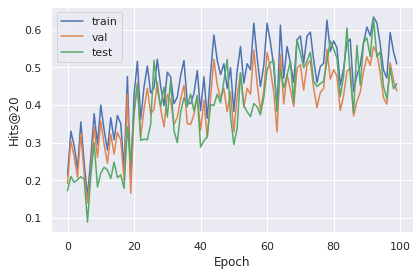

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

plt.plot(train_hits_20, label = 'train')
plt.plot(val_hits_20, label = 'val')
plt.plot(test_hits_20, label = 'test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Hits@20')

plt.tight_layout()
plt.savefig('gnn_eval.pdf')
plt.show()